In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display
from matplotlib import patches
from collections import deque

# MDP class

In [3]:
class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [Page 646]"""

    def __init__(self, start_state, actions_list,
                 terminals, transitions, reward, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        self.start_state = start_state
        self.actions_list = actions_list
        self.terminals = terminals
        self.transitions = transitions
        self.reward = reward
        self.gamma = gamma

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actions_list

In [4]:
orientations = FORWARD, RIGHT, UP, BACKWARD, LEFT, DOWN = [(1, 0, 0),
                                                           (0, 1, 0),
                                                           (0, 0, 1),
                                                           (-1, 0, 0),
                                                           (0, -1, 0),
                                                           (0, 0, -1)]

In [5]:
# Function to rotate a vector
def rotate_vector(vector, axis, angle_degree):
    if isinstance(vector, tuple):
        vector = np.array(vector)
    angle_rad = np.radians(angle_degree)
    # Rotation matrix around the x-axis
    if axis == 'x':
        rot_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle_rad), -np.sin(angle_rad)],
            [0, np.sin(angle_rad), np.cos(angle_rad)]
        ])
    # Rotation matrix around the y-axis
    elif axis == 'y':
        rot_matrix = np.array([
            [np.cos(angle_rad), 0, np.sin(angle_rad)],
            [0, 1, 0],
            [-np.sin(angle_rad), 0, np.cos(angle_rad)]
        ])
    # Rotation matrix around the z-axis
    elif axis == 'z':
        rot_matrix = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad), 0],
            [np.sin(angle_rad), np.cos(angle_rad), 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError('Axis must be either x or y, or z')
    # Apply the rotation
    result = np.dot(rot_matrix, vector)
    return np.round(result).astype(int)

In [6]:
def keep_forward(vector):
    return np.array(vector)


def turn_left(vector):
    # Rotate -90 degrees around the z-axis
    return rotate_vector(vector, 'z', -90)


def turn_right(vector):
    # Rotate 90 degrees around the z-axis
    return rotate_vector(vector, 'z', 90)


def turn_up(vector):
    # Rotate -90 degrees around the y-axis
    return rotate_vector(vector, 'y', -90)


def turn_down(vector):
    # Rotate 90 degrees around the y-axis
    return rotate_vector(vector, 'y', 90)


def turn_backward(vector):
    # Rotate 180 degrees around the y-axis
    return -np.array(vector)

In [7]:
def get_action_distribution(forward_prob, dim=3):
    if not (dim == 2 or dim == 3):
        raise ValueError("Dimension must be 2 or 3")
    distributions = [(forward_prob, keep_forward)]
    turn_actions = [turn_up, turn_down, turn_backward]
    if dim == 3:
        turn_actions += [turn_left, turn_right]

    complement_prob = 1 - forward_prob
    distributions.extend(((complement_prob / len(turn_actions), action) for action in turn_actions))
    return distributions

In [8]:
class GridMDP(MDP):

    def __init__(self, start_state, grid, action_distribution, terminals, gamma=.9):
        # grid.reverse()  # because we want row 0 on bottom, not on top
        reward = dict()
        self.states = set()
        # states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        y = 0
        for x in range(self.cols):
            for z in range(self.rows):
                self.states.add((x, y, z))
                reward[(x, y, z)] = grid[z][x]

        actions_list = [FORWARD, UP, DOWN, BACKWARD]
        self.action_distribution = action_distribution
        terminals = [(col, 0, row) for (row, col) in terminals]

        transitions = dict()
        for s in self.states:
            transitions[s] = dict()
            for a in actions_list:
                transitions[s][a] = self.calculate_T(s, a)
        super().__init__(start_state=start_state, actions_list=actions_list,
                         terminals=terminals, transitions=transitions,
                         reward=reward, gamma=gamma)

    def calculate_T(self, state, action):
        return [(prob, self.go(state, transform(action))) for prob, transform in self.action_distribution]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""
        if isinstance(direction, tuple):
            direction = np.array(direction)
        if isinstance(state, tuple):
            state = np.array(state)
        go_state = tuple(state + direction)
        return go_state if go_state in self.states else tuple(state)



In [9]:

rewards = [[-0.04, -0.04, -0.04, -1, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -0.04],
           [-0.04, -0.04, -0.04, -1, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -0.04],
           [-0.04, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -0.04],
           [-0.04, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -0.04],
           [-0.04, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -1, -1, -0.04, -0.04, +1],
           [-0.04, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -1, -1, -0.04, -0.04, -0.04]]

obstacles = [(0, 3), (0, 4), (0, 11), (1, 3), (1, 4), (1, 11), (2, 4), (2, 8), (3, 4), (3, 8), (4, 1), (4, 7), (4, 8),
             (4, 9), (5, 1), (5, 7), (5, 8), (5, 9)]
finish = [(4, 12)]
start = [(1, 0)]

In [10]:
D = -1
T = +2
A = -0.04
rewards = [[A, A, A, D, D, A, A, A, A, A, A, D, A],
           [A, A, A, D, D, A, A, A, A, A, A, D, A],
           [A, A, A, A, D, A, A, A, D, A, A, A, A],
           [A, A, A, A, D, A, A, A, D, A, A, A, A],
           [A, D, A, A, A, A, A, D, D, D, A, A, T],
           [A, D, A, A, A, A, A, D, D, D, A, A, A]]

obstacles = [(0, 3), (0, 4), (0, 11), (1, 3), (1, 4), (1, 11), (2, 4), (2, 8), (3, 4), (3, 8), (4, 1), (4, 7), (4, 8),
             (4, 9), (5, 1), (5, 7), (5, 8), (5, 9)]
finish = [(4, 12)]
start = [(1, 0)]

In [11]:
def get_grid_1(D, T, A):
    return [[A, A, A, D, D, A, A, A, A, A, A, D, A],
            [A, A, A, D, D, A, A, A, A, A, A, D, A],
            [A, A, A, A, D, A, A, A, D, A, A, A, A],
            [A, A, A, A, D, A, A, A, D, A, A, A, A],
            [A, D, A, A, A, A, A, D, D, D, A, A, T],
            [A, D, A, A, A, A, A, D, D, D, A, A, A]]

In [12]:
grid_mdp = GridMDP(start_state=start, grid=rewards,
                   action_distribution=get_action_distribution(forward_prob=1, dim=2),
                   terminals=obstacles + finish, gamma=1)

# Value iteration

In [13]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action. [Equation 17.4]"""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi


def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""

    return sum(p * U[s1] for (p, s1) in mdp.T(s, a))


def value_iteration(mdp, epsilon=1e-3):
    utilities_history = []
    policies_history = []

    U_current = mdp.reward.copy()
    utilities_history.append(U_current.copy())
    policies_history.append(best_policy(mdp, U_current))

    actions, R, T, gamma = mdp.actions, mdp.R, mdp.T, mdp.gamma
    while True:
        delta = 0.0
        U_previous = U_current.copy()
        for s in mdp.states:
            U_current[s] = R(s) + gamma * max(sum(p * U_previous[s1] for (p, s1) in T(s, a))
                                              for a in mdp.actions(s))
            delta = max(delta, abs(U_current[s] - U_previous[s]))
        utilities_history.append(U_current.copy())
        policies_history.append(best_policy(mdp, U_current))
        if delta <= epsilon * (1 - gamma) / gamma:
            return utilities_history, policies_history

In [494]:
class Visualizer2D:
    def __init__(self, start_state, obstacles, finish_state, iteration_algorithm, vmin=-10.0, vmax=10.0):
        self.start_state = start_state
        self.obstacles = obstacles
        self.finish_state = finish_state
        self.terminals = obstacles + finish_state
        self.iteration_algorithm = iteration_algorithm

        self.vmin = vmin
        self.vmax = vmax
        self.kwargs = None
        self.mdp = None
        self.utilities = None
        self.policies = None

        self.iteration_slider = widgets.IntSlider(min=1, max=None, step=1, value=None,
                                                  description='Iteration')

    def update(self, iteration, **kwargs):
        if self.kwargs != kwargs:
            grid = get_grid_1(D=kwargs['D'], T=kwargs['T'], A=kwargs['A'])
            distribution = get_action_distribution(forward_prob=kwargs['forward_prob'], dim=2)
            self.mdp = GridMDP(start_state=self.start_state, grid=grid, action_distribution=distribution,
                               terminals=self.terminals, gamma=kwargs['gamma'])
            self.utilities, self.policies = self.iteration_algorithm(self.mdp, epsilon=kwargs['epsilon'])
            
            if self.kwargs is None:
                self.kwargs = kwargs
                self.iteration_slider.max = len(self.utilities)
                self.iteration_slider.value = len(self.utilities)
                self.visualize(iteration)
            else:
                self.kwargs = kwargs
                self.iteration_slider.max = len(self.utilities)
                self.iteration_slider.value = len(self.utilities)
        else:
            self.visualize(iteration)

    def visualize(self, iteration):

        fig, axes = plt.subplots(ncols=2, figsize=(12, 20), constrained_layout=True, gridspec_kw={'width_ratios': [grid_mdp.cols / grid_mdp.rows, 1]})
        self.draw_utility(iteration, axes[0])
        self.draw_action_distribution(axes[1])
        # fig.patch.set_facecolor('none')
        plt.show()

    def draw_utility(self, iteration, ax):
        # Define the colors - each entry in the list corresponds to a point in the colormap range
        colors = ["salmon", "white", "lightblue"]

        # Create the colormap
        cmap = mcolors.LinearSegmentedColormap.from_list("utility", colors)
        data = self.utilities[iteration - 1]
        policy = self.policies[iteration - 1]
        grid = []
        grid_P = []
        for row in range(grid_mdp.rows):
            current_row_U = []
            current_row_P = []
            for column in range(grid_mdp.cols):
                current_row_U.append(data[(column, 0, row)])
                current_row_P.append(policy[column, 0, row])
            grid.append(current_row_U)
            grid_P.append(current_row_P)
        ax.imshow(grid, vmin=self.vmin, vmax=self.vmax, cmap=cmap, interpolation='nearest')
        ax.axis('off')
        self.draw_surroundings(grid, grid_P, ax)

        

    def draw_policy(self, iteration, ax):
        data = self.utilities[iteration - 1]
        grid = []
        for row in range(grid_mdp.rows):
            current_row = []
            for column in range(grid_mdp.cols):
                current_row.append(data[(column, 0, row)])
            grid.append(current_row)

    def draw_surroundings(self, grid, grid_P, ax):
        ax.add_patch(
            patches.Rectangle((self.start_state[0][1] - 0.5, self.start_state[0][0] - 0.5), 1, 1, edgecolor='none',
                              facecolor='green', alpha=0.5))
        ax.add_patch(
            patches.Rectangle((self.finish_state[0][1] - 0.5, self.finish_state[0][0] - 0.5), 1, 1, edgecolor='none',
                              facecolor='blue', alpha=0.5))
        actions_p = self.actions_path(grid_P)
        for col in range(len(grid)):
            for row in range(len(grid[0])):
                if (col, row) in obstacles:
                    rect = patches.Rectangle((row - 0.5, col - 0.5), 1, 1, edgecolor='none',
                                             facecolor='black', alpha=0.5)
                    ax.add_patch(rect)
                else:
                    action = grid_P[col][row]
                    facecolor = 'black'
                    if (row, 0, col) in actions_p:
                        facecolor = 'blue'
                    if action:
                        dx, dy = action[0], action[2]
                        if dx != 0:
                            if dx == -1:
                                arrow = patches.FancyArrow(row - 0.1 * dx, col - 0.25 * dx, 0.1 * action[0],
                                                           0.1 * action[2], width=0.05, edgecolor='none',
                                                           facecolor=facecolor,
                                                           alpha=0.8)
                            else:
                                arrow = patches.FancyArrow(row - 0.1 * dx, col + 0.25 * dx, 0.1 * action[0],
                                                           0.1 * action[2], width=0.05, edgecolor='none',
                                                           facecolor=facecolor,
                                                           alpha=0.8)
                        else:
                            if dy == -1:
                                arrow = patches.FancyArrow(row + 0.1 * dx, col - 0.45 * dy, 0.1 * action[0],
                                                           0.1 * action[2], width=0.05, edgecolor='none',
                                                           facecolor=facecolor,
                                                           alpha=0.8)
                            else:
                                arrow = patches.FancyArrow(row + 0.1 * dx, col + 0.1 * dy, 0.1 * action[0],
                                                       0.1 * action[2], width=0.05, edgecolor='none',
                                                       facecolor=facecolor,
                                                       alpha=0.8)
                        ax.add_patch(arrow)
                value = grid[col][row]
                ax.text(row, col - 0.1, f"{value:.2f}", va='center', ha='center')

    def actions_path(self, grid_P):
        start = (self.start_state[0][1], 0, self.start_state[0][0])
        visited = {start}
        opened = deque([start])
        while opened:
            state = opened.pop()
            action = grid_P[state[2]][state[0]]
            if action is None:
                continue
            neighbor = tuple(np.array(state) + np.array(action))
            if neighbor not in self.mdp.states:
                continue
            if neighbor in self.terminals:
                continue
            if neighbor not in visited:
                opened.append(neighbor)
                visited.add(neighbor)
        return visited
    
    def draw_action_distribution(self, ax):
        ax.imshow([[1]], vmin=0, vmax=1,  cmap='gray')
        
        forwad_dir = (0, 0, -1)
        
        for prob, turn_func in self.mdp.action_distribution:
            facecolor = 'black'
            if turn_func == keep_forward:
                facecolor = 'blue'
            dir = turn_func(forwad_dir)
            dx, dy, dz = dir
            arrow = patches.FancyArrow(0, 0, 0.25 * prob * dx + 0.1*  dx,
                                       0.25 * prob * dz + 0.1 * dz, width=0.025, edgecolor='none',
                                       facecolor=facecolor)
            ax.add_patch(arrow)

        custom_legend_handles = [
            Line2D([0], [1], color='blue', lw=2, marker='>', linestyle='None', label=f"Forward probability: {self.kwargs['forward_prob']:.2f}"),
            Line2D([0], [1], color='black', lw=2, marker='>', linestyle='None', label=f"Sideways probability: {(1 - self.kwargs['forward_prob'])/3:.2f}"),
        ]
    
        # Add the custom legend to the second plot
        ax.legend(handles=custom_legend_handles, loc='lower right')
        
        ax.axis('off')
        
 
        

In [495]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [496]:

VMIN = -1.0
VMAX = 1.0

visualizer = Visualizer2D(start_state=start, obstacles=obstacles, finish_state=finish,
                          iteration_algorithm=value_iteration,
                          vmin=VMIN, vmax=VMAX,
                          )

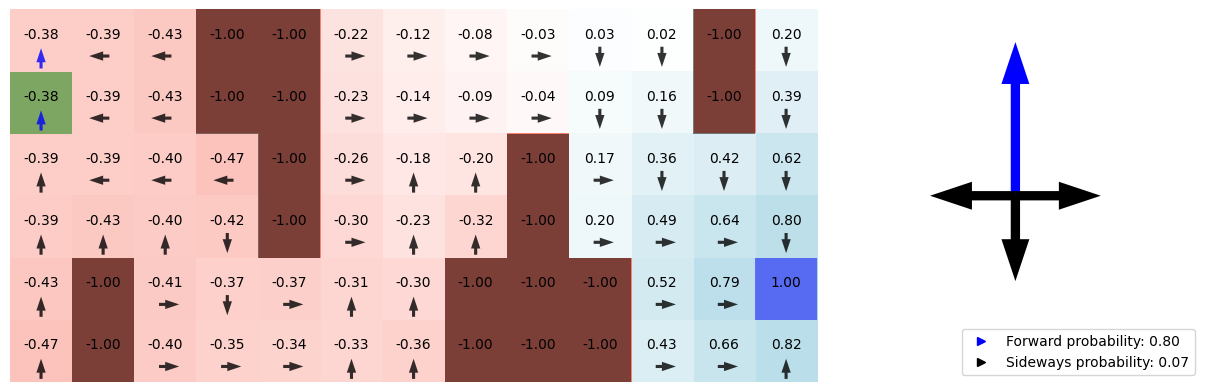

In [497]:
visualizer.update(30, D=-1.0, T=1.0, A=-0.04, forward_prob=0.8, gamma=0.9, epsilon=1e-3)

In [310]:
slider_style = {'description_width': 'initial'}

D_slider = widgets.FloatSlider(min=VMIN, max=0.0, step=0.01, value=-1.0, description='Obstacles')
T_slider = widgets.FloatSlider(min=0.0, max=VMAX, step=0.01, value=1.0, description='Finish')
A_slider = widgets.FloatSlider(min=VMIN, max=VMAX, step=0.01, value=-0.04, description='Air')
forward_prob_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.8,
                                          description='Forward prob', style=slider_style)
gamma_slider = widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=0.9, description='Gamma')
epsilon_slider = widgets.FloatSlider(min=1e-6, max=1e-0, step=1e-6, value=1e-3, description='Epsilon',
                                     readout_format='.2e')
interactive_plot = widgets.interactive(visualizer.update,
                                       iteration=visualizer.iteration_slider,
                                       D=D_slider,
                                       T=T_slider,
                                       A=A_slider,
                                       forward_prob=forward_prob_slider,
                                       gamma=gamma_slider,
                                       epsilon=epsilon_slider
                                       )
display(interactive_plot)

interactive(children=(IntSlider(value=57, description='Iteration', max=57, min=1), FloatSlider(value=-1.0, des…

In [18]:
get_action_distribution(forward_prob=0.4, dim=2)

[(0.4, <function __main__.keep_forward(vector)>),
 (0.19999999999999998, <function __main__.turn_up(vector)>),
 (0.19999999999999998, <function __main__.turn_down(vector)>),
 (0.19999999999999998, <function __main__.turn_backward(vector)>)]

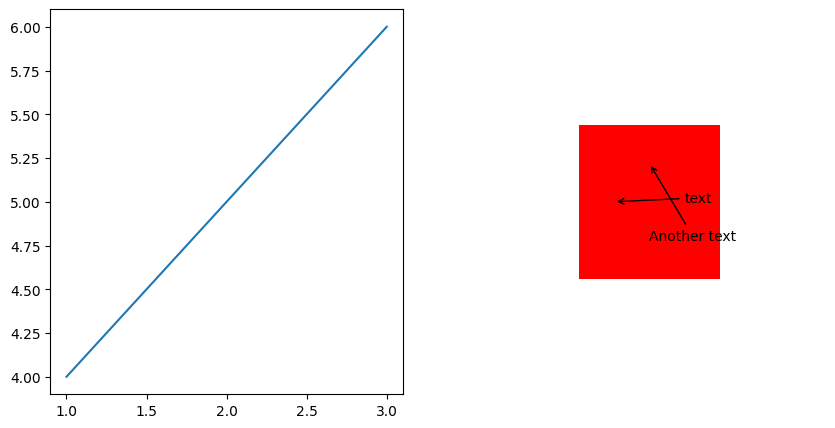

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Example data for the first plot
ax1.plot([1, 2, 3], [4, 5, 6])

# Add a white rectangle to the second subplot (ax2)
rectangle = patches.Rectangle((0.3, 0.3), 0.4, 0.4, edgecolor='none', facecolor='red', transform=ax2.transAxes)
ax2.add_patch(rectangle)

# Draw arrows in the center of the white rectangle
ax2.annotate('Another text', xy=(0.5, 0.6), xytext=(0.5, 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'), transform=ax2.transAxes)
ax2.annotate('text', xy=(0.4, 0.5), xytext=(0.6, 0.5), arrowprops=dict(facecolor='black', arrowstyle='->'), transform=ax2.transAxes)

# Hide axes in the second plot for better visibility
ax2.axis('off')

# Display the plot
plt.show()

In [39]:
# Create a text input widget
text_input = widgets.Text(
    value='',
    description='Enter value:',
    continuous_update=False  # This can be set to True if you want real-time updates
)

output = widgets.Output()


# Function to handle input
def handle_input(change):
    # Perform an action with the new input value
    # 'change' is a dictionary containing details about the state change,
    # including the new value under the key 'new'.
    with output:
        output.clear_output()
        print("Value entered:", change.new)


# Attach the function to the 'value' trait of the input box.
# This will fire the function whenever the user presses enter or shifts focus from the input box.
text_input.observe(handle_input, names='value')

# Display the text input box
display(text_input, output)

Text(value='', continuous_update=False, description='Enter value:')

Output()

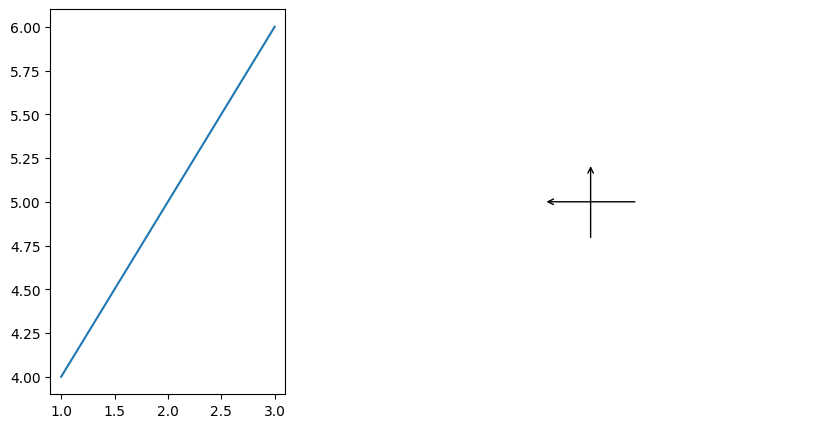

In [129]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

# Create a figure
fig = plt.figure(figsize=(10, 5))

# Create GridSpec with 1 row and 2 columns, setting width ratios
gs = GridSpec(1, 2, width_ratios=[1, 2], height_ratios=[1])

# Add the first subplot (ax1) in the grid
ax1 = fig.add_subplot(gs[0, 0])
# Example data for the first plot
ax1.plot([1, 2, 3], [4, 5, 6])

# Add the second subplot (ax2) in the grid
ax2 = fig.add_subplot(gs[0, 1])
# Add a white rectangle to the second subplot using axes coordinates
rectangle = patches.Rectangle((0.3, 0.3), 0.4, 0.4, edgecolor='none', facecolor='white', transform=ax2.transAxes)
ax2.add_patch(rectangle)

# Add arrows to the second subplot
ax2.annotate('', xy=(0.5, 0.6), xytext=(0.5, 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'), transform=ax2.transAxes)
ax2.annotate('', xy=(0.4, 0.5), xytext=(0.6, 0.5), arrowprops=dict(facecolor='black', arrowstyle='->'), transform=ax2.transAxes)

# Hide axes in the second plot for better visibility
ax2.axis('off')
fig.patch.set_facecolor('none')
# Display the plot
plt.show()

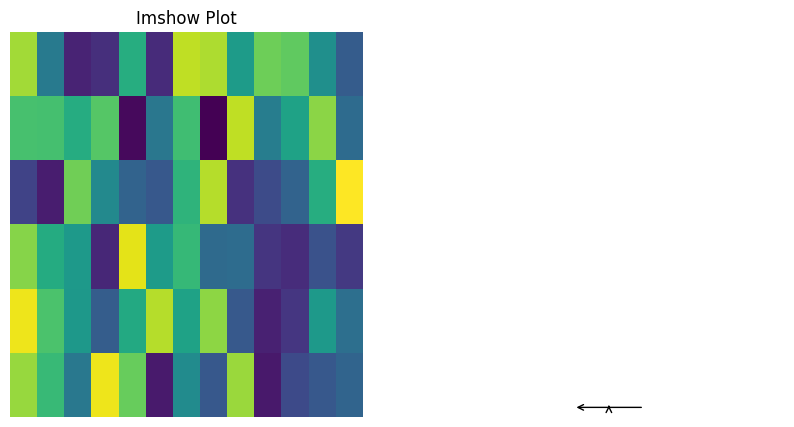

In [160]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Create some example data for the imshow plot
data = np.random.rand(6, 13)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the imshow data on the first axis
cax = ax1.imshow(data, aspect='auto')
ax1.set_title('Imshow Plot')
ax1.axis('off')
# Get the position and size of the imshow plot
bbox = cax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
height = bbox.height

# Adjust the height of the second axis to match the first
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width, height / fig.dpi])

# Add a white rectangle to the second subplot using axes coordinates
rectangle = patches.Rectangle((0, 0), 1, 1, edgecolor='none', facecolor='white', transform=ax2.transData)
ax2.add_patch(rectangle)

# Add arrows to the second subplot
ax2.annotate('', xy=(0.5, 0.6), xytext=(0.5, 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'), transform=ax2.transAxes)
ax2.annotate('', xy=(0.4, 0.5), xytext=(0.6, 0.5), arrowprops=dict(facecolor='black', arrowstyle='->'), transform=ax2.transAxes)

# Hide axes in the second plot for better visibility
ax2.axis('off')
fig.patch.set_facecolor('none')
# Display the plot
plt.show()

# Policy iteration

# 2D

# 3D